# Asari table preprocessing

In [89]:
# !pip install seaborn

In [90]:
import pandas as pd
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from random import randrange

In [91]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [92]:
asari_out_fdr = "../../input/HILICpos_mzML/output_asari_project_224113827_targeted_search/"
targeted_file = "../../input/HILICpos_mzML/output_asari_project_224113827_targeted_search/simp-m-targeted_extraction-Feature_table.tsv"
metadata_file = "../../input/sequence_file/clean_meta_df_wt1_HILICpos.csv"
mode = "HILICpos"
group_percNA_threshold = 0.3 # < percNA, should be presented in any group

In [93]:
output_dir = "../../output/preprocessing_on_targetd" + str(randrange(0,100))

In [94]:
try:
    os.mkdir(output_dir)
except:
    print("not done")

In [95]:
feat_df = pd.read_csv(os.path.join(asari_out_fdr,'preferred_Feature_table.tsv'),sep = '\t')

In [96]:
feat_df.head()

,id_number,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,detection_counts,nist_1,G1_Naive_1_300_1,G1_Naive_2_300_1,G1_Naive_3_300_1,G2_R5pos_1_142_1,G2_R5pos_2_200_1,G2_R5pos_3_150_1,G3_R5neg_1a_655_1,G3_R5neg_1b_655_1,G3_R5neg_2a_687_1,G3_R5neg_2b_687_1,G3_R5neg_3a_865_1,G3_R5neg_3b_865_1,nist_3,nist_5,q3June2014_1b_1,q3June2014_1b_3,q3June2014_1b_5,q3June2014_2a_1,q3June2014_2a_3,q3June2014_2a_5,q3June2014_2b_1,q3June2014_2b_3,q3June2014_2b_5
0,F3,85.0477,61.69,58.54,64.84,0,22754577,1.00,0.86,1676,12,1224772,0,0,0,0,0,0,0,0,0,0,0,0,2637326,2387814,1207724,1045345,1231387,1400313,1448103,797729,819349,820781,800500
1,F5,115.0593,69.31,66.16,72.46,1358,4746480,1.00,0.92,321,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,535580,781938,0,646521,539292,660628,0,0,1252403
2,F11,115.0631,27.79,26.22,30.95,1359,192893328,0.92,0.72,150,12,6279652,0,0,0,0,0,0,0,0,0,0,0,0,25659794,27734392,22639464,23034231,24280391,24060609,24157986,24912400,25260023,23476439,22791126
3,F12,85.0647,62.21,59.06,64.84,2,4204718,1.00,0.93,39,12,0,163014,185168,311919,133599,101565,110948,368629,137644,103785,334050,410553,282564,0,0,0,0,0,0,0,0,0,0,0
4,F13,85.0647,65.10,64.84,67.47,2,1247893,1.00,0.87,27,12,0,134222,44310,101329,80291,136212,83206,367391,130567,65650,117937,166892,168016,0,0,0,0,0,0,0,0,0,0,0


In [97]:
print(f'number of features are: {feat_df.shape[0]}')

number of features are: 9756


In [98]:
meta_df = pd.read_csv("../../input/sequence_file/CD8_Tcell_05222018_180522154617.csv", header = 1 )

In [99]:
meta_df.head()

,Sample Type,File Name,Sample ID,Path,Instrument Method,Process Method,Calibration File,Position,Inj Vol,Comment,Sample Name
0,Unknown,yw_180522_M345_001,nist_1,C:\Xcalibur\data\CD8TCell_Rafi\batch1,C:\Xcalibur\methods\Clinical_Biomarkers_Lab_Me...,NaN,NaN,GA1,10,1,NaN
1,Unknown,yw_180522_M345_002,nist_2,C:\Xcalibur\data\CD8TCell_Rafi\batch1,C:\Xcalibur\methods\Clinical_Biomarkers_Lab_Me...,NaN,NaN,GA1,10,1,NaN
2,Unknown,yw_180522_M345_003,nist_3,C:\Xcalibur\data\CD8TCell_Rafi\batch1,C:\Xcalibur\methods\Clinical_Biomarkers_Lab_Me...,NaN,NaN,GA1,10,1,NaN
3,Unknown,yw_180522_M345_004,nist_4,C:\Xcalibur\data\CD8TCell_Rafi\batch1,C:\Xcalibur\methods\Clinical_Biomarkers_Lab_Me...,NaN,NaN,GA1,10,1,NaN
4,Unknown,yw_180522_M345_005,nist_5,C:\Xcalibur\data\CD8TCell_Rafi\batch1,C:\Xcalibur\methods\Clinical_Biomarkers_Lab_Me...,NaN,NaN,GA1,10,1,NaN


In [100]:
def extract_list2list(regExpr,a_list):
    return([re.search(regExpr,x)[0] for x in a_list if re.search(regExpr,x)])

def extract_list2dict(regExpr,a_list):
    return({x:re.search(regExpr,x)[0] for x in a_list if re.search(regExpr,x)})

In [101]:
def refactor_metadata(meta_df,sample_col):
    rs_d = extract_list2dict("([R|N][0-9|a-z]+)\\_[a-z|0-9]+",sample_col)
    qstd_d = extract_list2dict("(q3June2014\\_[a-z|0-9]+)",sample_col)
    nist_d = extract_list2dict("(nist\\_[a-z|0-9])",sample_col)

    full_d = {}
    full_d.update(rs_d)
    full_d.update(qstd_d)
    full_d.update(nist_d) 
    for i, row in meta_df.iterrows():
        if row['Sample ID'] in full_d:
            meta_df.loc[i,'tID'] = full_d[row['Sample ID']]
    
    subset_meta_df = meta_df.loc[[isinstance(x,str) for x in meta_df['tID']],['tID','Sample ID']]
    subset_meta_df['tID_dedup'] = extract_list2list("(?i)([0-9|a-z]+\\_[0-9])",subset_meta_df['tID'])
    subset_meta_df['class'] = extract_list2list("(?i)([0-9|a-z])+",subset_meta_df['tID_dedup'])
    return(subset_meta_df)

In [102]:
sample_col = feat_df.columns[11:] # select the column names decode samples
clean_meta_df = refactor_metadata(meta_df,sample_col)
clean_meta_df = clean_meta_df.reset_index()

In [103]:
# Define biological samples
clean_meta_df['biological_samples'] = 'No'
clean_meta_df.loc[clean_meta_df['class'].isin(['R5pos','Naive','R5neg']),'biological_samples'] = 'Yes'

In [104]:
test_list = clean_meta_df.loc[clean_meta_df['biological_samples'] == 'Yes','Sample ID']
clean_meta_df.loc[clean_meta_df['biological_samples'] == 'Yes','cell_number'] = [re.search('[a-z]+\\_[0-9|a-z]+\\_([0-9]+)',x)[1] for x in test_list if re.search('[a-z]+\\_[0-9|a-z]+\\_([0-9]+)',x)]

#### correct the nist which should be actually technical duplicates

In [105]:
clean_meta_df.loc[clean_meta_df['class'] == 'nist', 'tID_dedup'] = 'nist'

In [106]:
clean_meta_df

,index,tID,Sample ID,tID_dedup,class,biological_samples,cell_number
0,0,nist_1,nist_1,nist,nist,No,NaN
1,2,nist_3,nist_3,nist,nist,No,NaN
2,4,nist_5,nist_5,nist,nist,No,NaN
3,12,q3June2014_1b,q3June2014_1b_1,q3June2014_1,q3June2014,No,NaN
4,14,q3June2014_1b,q3June2014_1b_3,q3June2014_1,q3June2014,No,NaN
5,16,q3June2014_1b,q3June2014_1b_5,q3June2014_1,q3June2014,No,NaN
6,18,R5pos_1,G2_R5pos_1_142_1,R5pos_1,R5pos,Yes,142
7,20,R5pos_2,G2_R5pos_2_200_1,R5pos_2,R5pos,Yes,200
8,22,R5pos_3,G2_R5pos_3_150_1,R5pos_3,R5pos,Yes,150
9,24,Naive_1,G1_Naive_1_300_1,Naive_1,Naive,Yes,300


#### create a dictionary to map samples with technical duplicates

In [107]:
dedup_dict = {}
dedupIDs = set(clean_meta_df['tID_dedup'])
for dedupID in dedupIDs:
    dedup_dict[dedupID] = clean_meta_df.loc[clean_meta_df['tID_dedup'] == dedupID,'Sample ID'].tolist()

In [108]:
dedup_dict

{'nist': ['nist_1', 'nist_3', 'nist_5'],
 'q3June2014_1': ['q3June2014_1b_1', 'q3June2014_1b_3', 'q3June2014_1b_5'],
 'R5neg_1': ['G3_R5neg_1a_655_1', 'G3_R5neg_1b_655_1'],
 'Naive_2': ['G1_Naive_2_300_1'],
 'Naive_1': ['G1_Naive_1_300_1'],
 'R5pos_2': ['G2_R5pos_2_200_1'],
 'q3June2014_2': ['q3June2014_2a_1',
  'q3June2014_2a_3',
  'q3June2014_2a_5',
  'q3June2014_2b_1',
  'q3June2014_2b_3',
  'q3June2014_2b_5'],
 'R5neg_3': ['G3_R5neg_3a_865_1', 'G3_R5neg_3b_865_1'],
 'Naive_3': ['G1_Naive_3_300_1'],
 'R5pos_1': ['G2_R5pos_1_142_1'],
 'R5pos_3': ['G2_R5pos_3_150_1'],
 'R5neg_2': ['G3_R5neg_2a_687_1', 'G3_R5neg_2b_687_1']}

In [109]:
clean_meta_df.to_csv("../../input/sequence_file/clean_meta_df_wt1_HILICpos.csv",index = False)

---------

## Preprocess the asari table 
- Separate metainfo_df & data_df; convert zero to np.nan

In [110]:
feat_df.index = feat_df['id_number']

In [111]:
end_index = 11

In [112]:
data_df = feat_df.iloc[:,end_index:]

In [113]:
metainfo_df = feat_df.iloc[:,0:end_index]

In [114]:
# turn all zero to NA for easy manipulation later
data_df[data_df == 0 ] = np.nan

---

## Perform deduplication of technical replicates

In [115]:
def deduplicate(data_df,dedup_dict = dedup_dict):
    if data_df.eq(0).any().any(): # a way to check if any cell is zero
        print("warning: detet zero in dataset")
    else:
        new_df = pd.DataFrame()
        for dedup_name,dup_name_list in dedup_dict.items():
            print(dedup_name)
            subset_df = data_df[dup_name_list]
            print(subset_df.columns)
            averaged_list = subset_df.apply(lambda x: x.mean(skipna = True), axis = 1)
            new_df[dedup_name] = averaged_list
        new_df = new_df[new_df.columns.sort_values()]
        return(new_df)

In [116]:
data_df_dedup = deduplicate(data_df,dedup_dict)

nist
Index(['nist_1', 'nist_3', 'nist_5'], dtype='object')
q3June2014_1
Index(['q3June2014_1b_1', 'q3June2014_1b_3', 'q3June2014_1b_5'], dtype='object')
R5neg_1
Index(['G3_R5neg_1a_655_1', 'G3_R5neg_1b_655_1'], dtype='object')
Naive_2
Index(['G1_Naive_2_300_1'], dtype='object')
Naive_1
Index(['G1_Naive_1_300_1'], dtype='object')
R5pos_2
Index(['G2_R5pos_2_200_1'], dtype='object')
q3June2014_2
Index(['q3June2014_2a_1', 'q3June2014_2a_3', 'q3June2014_2a_5', 'q3June2014_2b_1', 'q3June2014_2b_3', 'q3June2014_2b_5'], dtype='object')
R5neg_3
Index(['G3_R5neg_3a_865_1', 'G3_R5neg_3b_865_1'], dtype='object')
Naive_3
Index(['G1_Naive_3_300_1'], dtype='object')
R5pos_1
Index(['G2_R5pos_1_142_1'], dtype='object')
R5pos_3
Index(['G2_R5pos_3_150_1'], dtype='object')
R5neg_2
Index(['G3_R5neg_2a_687_1', 'G3_R5neg_2b_687_1'], dtype='object')


#### Quick deduplicated data reporting

<Axes: >

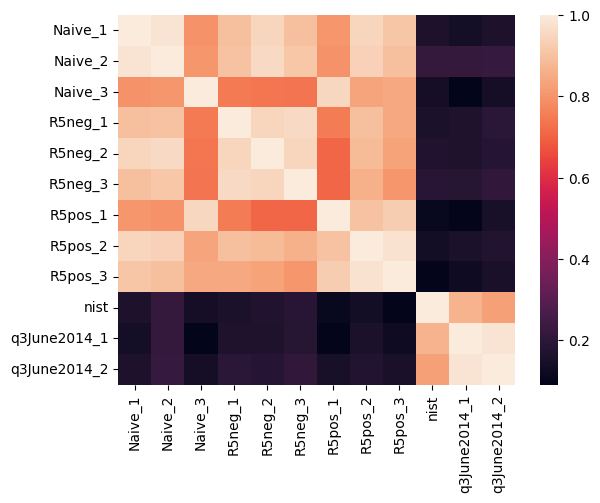

In [117]:
# quickly check if blank needs to be removed
# Note that for drawing this, it will be better to not convert 0 to NA
sns.heatmap(data_df_dedup.corr())

-----

## Sample present reporting

### functions

In [118]:
def select_column_regExpr(feat_df,regPattern):
    res_df = feat_df.loc[:,[x for x in feat_df.columns \
                            if re.search(regPattern,x)]]
    return(res_df)

def report_basic_stat(df):
    '''
    Default calculate mean and percentage of NA for any table.
    Before inputting the table, filtering steps may need to be done like correlation of blank matrix and filter out samples.
    '''
    if any(df == 0):
        df[df == 0] = np.nan
    mean_list = df.apply(lambda x: x.mean(skipna = True), axis=1)
    percNA_list = df.apply(lambda x: x.isna()).sum(axis = 1)/df.shape[1]
    df_stat_tab = pd.DataFrame({
                           'percNA':percNA_list, 
                           'mean': mean_list})
    df_dict = df_stat_tab.to_dict('index')
    return(df_dict)

def select_and_report(feat_df,regPattern):
    sel_df = select_column_regExpr(feat_df,regPattern)
    rep_dict = report_basic_stat(sel_df)
    return(rep_dict)

### perform sample present report

In [119]:
naive_dict = select_and_report(data_df_dedup,'Naive')
R5neg_dict = select_and_report(data_df_dedup,'R5neg')
R5pos_dict = select_and_report(data_df_dedup,'R5pos')

In [120]:
dict_of_dict = {'Naive': naive_dict,
                'R5neg': R5neg_dict,
                'R5pos': R5pos_dict
}

In [121]:
def dicts2table(dict_of_dict):
    new_df = pd.DataFrame()
    for k,v in dict_of_dict.items():
        tab = pd.DataFrame(v).transpose()
        tab.columns = [k + "_" + x for x in tab.columns]
        new_df =  pd.concat([new_df, tab], axis=1)
    return(new_df)

In [122]:
stat_tab = dicts2table(dict_of_dict)

In [123]:
stat_tab

,Naive_percNA,Naive_mean,R5neg_percNA,R5neg_mean,R5pos_percNA,R5pos_mean
F3,1.000000,NaN,1.0,NaN,1.000000,NaN
F5,1.000000,NaN,1.0,NaN,1.000000,NaN
F11,1.000000,NaN,1.0,NaN,1.000000,NaN
F12,0.000000,220033.666667,0.0,272870.833333,0.000000,115370.666667
F13,0.000000,93287.000000,0.0,169408.833333,0.000000,99903.000000
...,...,...,...,...,...,...
F18900,0.000000,140482.333333,0.0,100424.000000,0.000000,29968.666667
F18902,1.000000,NaN,1.0,NaN,1.000000,NaN
F18909,1.000000,NaN,1.0,NaN,1.000000,NaN
F18910,0.666667,101892.000000,1.0,NaN,0.666667,59318.000000


------

## add stat into feature table and rearrange sample order

In [124]:
metainfo_df.columns

Index(['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts'], dtype='object')

In [125]:
data_df_dedup.columns

Index(['Naive_1', 'Naive_2', 'Naive_3', 'R5neg_1', 'R5neg_2', 'R5neg_3', 'R5pos_1', 'R5pos_2', 'R5pos_3', 'nist', 'q3June2014_1', 'q3June2014_2'], dtype='object')

In [126]:
def group_filtering(feat_df = data_df_dedup,
                    stat_df = stat_tab,
                    group_percNA_threshold = group_percNA_threshold,
                    group_signature = ['R5pos','R5neg','Naive'], # the group you would like to do filtering
                    percNA_suffix_inRegExpr = '\\_percNA'):
    '''
    Perform group filtering
    
    '''
    group_percNA_df = select_column_regExpr(stat_df,('|').join([x + percNA_suffix_inRegExpr \
                                                                            for x in group_signature]))
    group_percNA_df_filtered = group_percNA_df.loc[group_percNA_df.apply(lambda x: x < group_percNA_threshold,
                                                                         axis =1).any(axis = 1),
                                                   :]
    new_stat_df = stat_df.loc[group_percNA_df_filtered.index,:]
    new_feat_df = feat_df.loc[group_percNA_df_filtered.index,:]
    
    return(new_feat_df,new_stat_df)

In [127]:
grp_filt_df, grp_filt_stat_df = group_filtering(feat_df = data_df_dedup,
                                                stat_df = stat_tab,
                                                group_percNA_threshold = group_percNA_threshold,
                                                group_signature = ['R5pos','R5neg','Naive'],
                                                percNA_suffix_inRegExpr = '\\_percNA')

In [128]:
grp_filt_stat_df.shape

(2771, 6)

In [129]:
print(f"Before filtering, there are {feat_df.shape[0]} number of features\n \
finally after group filtering, there are {grp_filt_df.shape[0]} number of features")

Before filtering, there are 9756 number of features
 finally after group filtering, there are 2771 number of features


In [130]:
def combine_tables(list_df = [metainfo_df,grp_filt_stat_df,grp_filt_df],
                key_index_df = stat_tab):
    index = key_index_df.index
    new_list_df = []
    for df in list_df:
        new_list_df.append(df.loc[index,:])
    merge_df = pd.concat(new_list_df,axis =1)
    return(merge_df)

In [131]:
m_df = combine_tables(list_df = [metainfo_df,grp_filt_stat_df,grp_filt_df],  # the order of df directly afffects the order of the columns
                    key_index_df = grp_filt_stat_df)

In [132]:
m_df.to_csv(
    os.path.join(output_dir,
                   f"groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

grp_filt_stat_df.to_csv(
    os.path.join(output_dir,
                   f"groupFil{group_percNA_threshold}_{mode}_stattab.csv"))

---

---

---

## Filtering samples based on QC report (if needed)

In [133]:
# No outliers identified in this analysis, thus the outliers list is empty
outliers = []

In [134]:
def dropSamples(feat_df,dropSampleList):
    fil_feat_df = feat_df.drop(dropSampleList, axis = 1)
    return(fil_feat_df)

In [135]:
if outliers:
    outDrop_grp_filt_df = dropSamples(grp_filt_df, outliers)
    outDrop_grp_filt_df.to_csv(
        os.path.join(output_dir,
                       f"outDrop_blankM_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)
else:
    outDrop_grp_filt_df = m_df

## TIC normalization for top 1000 features

In [136]:
data_df = select_column_regExpr(outDrop_grp_filt_df,'R5pos\\_[0-9]+|R5neg\\_[0-9]+|Naive\\_[0-9]+')

In [137]:
data_df

,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3
F12,163014.0,185168.0,311919.0,253136.5,218917.5,346558.5,133599.0,101565.0,110948.0
F13,134222.0,44310.0,101329.0,248979.0,91793.5,167454.0,80291.0,136212.0,83206.0
F22,951141.0,1549923.0,2303649.0,1573781.0,1631864.0,1939811.5,1073833.0,1293960.0,2205156.0
F23,1548625.0,1551932.0,1486245.0,1650246.0,1840498.5,2827805.0,3623620.0,1749825.0,1248065.0
F41,NaN,453107.0,NaN,713299.5,669238.0,739421.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
F18891,6392290.0,5026236.0,4857830.0,2289110.0,2670815.0,NaN,6891936.0,8780176.0,7164335.0
F18893,3258080.0,2191849.0,2805161.0,2862131.5,3699737.5,2819226.0,NaN,1537621.0,NaN
F18894,NaN,NaN,NaN,4867033.0,7876994.0,8398675.0,NaN,NaN,NaN
F18899,6118743.0,20455443.0,4579867.0,7040105.0,10223075.0,9672716.0,1403790.0,6310722.0,2412656.0


In [138]:
import copy
def TIC_Normalization_TopN(data_df,
                           topN = 1000):
    if any(data_df.apply(lambda x: x == 0).any()):
        data_df[data_df == 0] = np.nan
    feature_ids = data_df.sum(axis = 1, 
                              skipna = True
                             ).sort_values(ascending = False)[0:topN].index
    meanTIC = data_df.loc[feature_ids,:].mean(axis=0,skipna = True)
    # print mean of TIC of the topN features
    print(meanTIC[0:5])
    factor_dict = dict(meanTIC/meanTIC.median())
    new_data_df = copy.deepcopy(data_df)
    for k,v in factor_dict.items():
        new_data_df[k] = [x/v for x in new_data_df[k]]
    # print meanTIC of topN features post-TIC normalization, should be the same
    print(new_data_df.loc[feature_ids,:].mean(axis=0,skipna = True)[0:5])
    
    # print meanTIC of all features post-TIC normalization, should be closed
    print(new_data_df.mean(axis=0,skipna = True)[0:5])
    
    return(new_data_df)

In [139]:
TICnorm_data_df = TIC_Normalization_TopN(data_df,topN = 1000)

Naive_1    2.252760e+07
Naive_2    2.275197e+07
Naive_3    2.785742e+07
R5neg_1    1.831777e+07
R5neg_2    1.898174e+07
dtype: float64
Naive_1    2.275197e+07
Naive_2    2.275197e+07
Naive_3    2.275197e+07
R5neg_1    2.275197e+07
R5neg_2    2.275197e+07
dtype: float64
Naive_1    1.096867e+07
Naive_2    1.110736e+07
Naive_3    1.039877e+07
R5neg_1    9.965258e+06
R5neg_2    9.781540e+06
dtype: float64


In [140]:
import numpy as np
import matplotlib.pyplot as plt

def bar_plot_TIC(df):
    TIC = df.sum(axis = 0)
    plt.bar(TIC.index, TIC)
    plt.show()

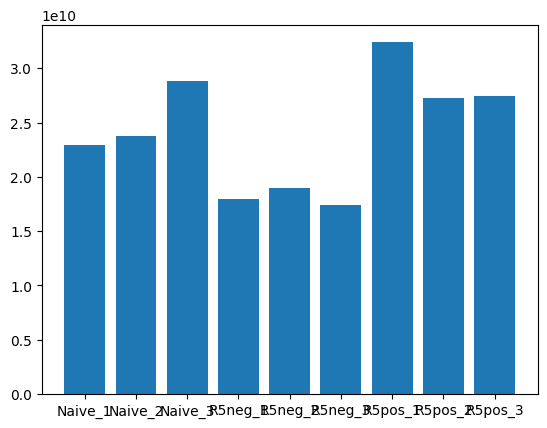

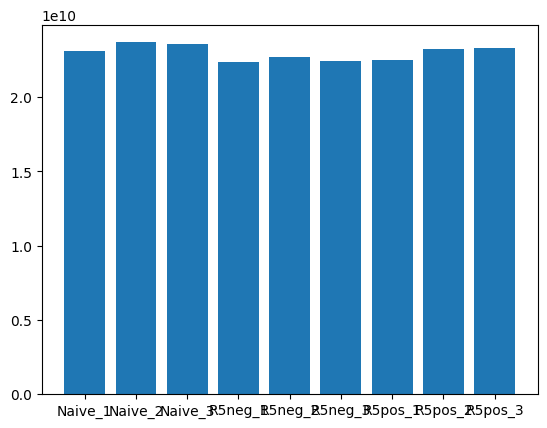

In [141]:
bar_plot_TIC(data_df)
bar_plot_TIC(TICnorm_data_df)

In [142]:
# I decide to just replace the 
def replace_col_wtTICnorm(feat_df = outDrop_grp_filt_df,
                          data_df = TICnorm_data_df):
    '''
    replace the same column of feature dataframe (feat_df) with the data_df that have the same column
    Return the feature dataframe. Note that the function is not limited to TIC normalized data.
    '''
    new_feat_df = copy.deepcopy(feat_df)
    for col in data_df.columns:
        new_feat_df[col] = data_df[col]

    return(new_feat_df)

In [143]:
TICnorm_feat_df = replace_col_wtTICnorm(feat_df = outDrop_grp_filt_df,
                          data_df = TICnorm_data_df)

In [144]:
TICnorm_feat_df.to_csv(
        os.path.join(output_dir,
                       f"TICnorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False) # rename if needed

------

------

------

------

------

## Normalization by cell number

In [145]:
import statistics as stat
def create_factor_dict(clean_meta_df,column2factor):
    factor_dict = {}
    new_df = clean_meta_df.loc[clean_meta_df['biological_samples'] == 'Yes',:]
    factor_dict = {row['tID_dedup']:row[column2factor] for i,row in new_df.iterrows()}
    median_value = stat.median(factor_dict.values())
    new_factor_dict = {k : float(v)/float(median_value) for k,v in factor_dict.items()}
    return(new_factor_dict)

In [146]:
def Customized_Normalization(data_df,
                           factor_dict):
    if data_df.apply(lambda x: x == 0).any().any():
        data_df[data_df == 0] = np.nan
        
    new_data_df = copy.deepcopy(data_df)
    for k,v in factor_dict.items():
        new_data_df[k] = [x/v for x in new_data_df[k]]
    
    # print meanTIC of all features post-TIC normalization, should be closed
    print(new_data_df.mean(axis=0,skipna = True)[0:5])
    
    return(new_data_df)

In [147]:
factor_dict = create_factor_dict(clean_meta_df,column2factor = "cell_number")
factor_dict

{'R5pos_1': 0.47333333333333333,
 'R5pos_2': 0.6666666666666666,
 'R5pos_3': 0.5,
 'Naive_1': 1.0,
 'Naive_2': 1.0,
 'Naive_3': 1.0,
 'R5neg_1': 2.183333333333333,
 'R5neg_2': 2.29,
 'R5neg_3': 2.8833333333333333}

In [148]:
data_df = select_column_regExpr(outDrop_grp_filt_df,'R5pos\\_[0-9]+|R5neg\\_[0-9]+|Naive\\_[0-9]+')
cellNorm_data_df = Customized_Normalization(data_df,factor_dict)

Naive_1    1.086051e+07
Naive_2    1.110736e+07
Naive_3    1.273221e+07
R5neg_1    3.674703e+06
R5neg_2    3.563600e+06
dtype: float64


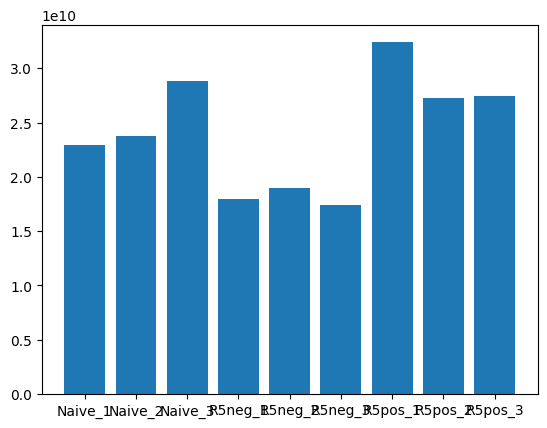

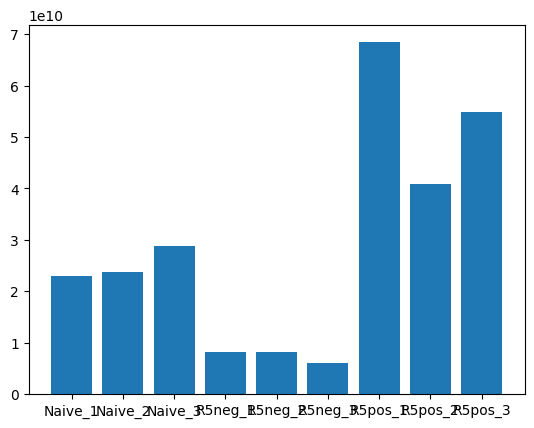

In [149]:
bar_plot_TIC(data_df)
bar_plot_TIC(cellNorm_data_df)

In [150]:
Cellnorm_feat_df = replace_col_wtTICnorm(feat_df = outDrop_grp_filt_df,
                          data_df = cellNorm_data_df)

In [151]:
Cellnorm_feat_df.to_csv(
        os.path.join(output_dir,
                       f"CellNumnorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False) # rename if needed

-----

## Summary
- normalization run two-ways:
    - based on top 1000 feature TIC: `TICnorm_data_df`
    - based on cell number: `cellNorm_data_df`

------

------

## Imputation with half minimum

In [152]:
def imputation(norm_data_df,full_asari_data_df,replace = 'half_minimum'):
    '''
    the row index should be matched btw. normalized data df & full asari df
    The reason to add full_asari_data_df is to add the true minimum across all samples. 
    It will better capture the baseline
    Default setting: if there is 0, then it will automatically deem as NA.
    full_asari_data_df can use the same dataset of norm_data_df
    norm_data_df can be exactly the same with not normalized dataset
    
    Output
    ======
    Return the NA filled norm_data_df
    ''' 
    
    # turn zero to NA
    norm_data_df[norm_data_df == 0] = np.nan
    full_asari_data_df[full_asari_data_df == 0] = np.nan
    
    if replace == 'half_minimum':
        for i,row in norm_data_df.iterrows():
            minimum_value = full_asari_data_df.loc[i,:].min()
            row.fillna(minimum_value/2,inplace = True) # imputation is minimum

    return(norm_data_df)

#### TICnorm data

In [153]:
TIC_full_data_df = select_column_regExpr(TICnorm_feat_df,'R5pos\\_[0-9]+|R5neg\\_[0-9]+|Naive\\_[0-9]+|q3June2014\\_[0-9]|nist')

In [154]:
# Make sure full asari data table including all different samples
TIC_full_data_df.columns

Index(['Naive_1', 'Naive_2', 'Naive_3', 'R5neg_1', 'R5neg_2', 'R5neg_3', 'R5pos_1', 'R5pos_2', 'R5pos_3', 'nist', 'q3June2014_1', 'q3June2014_2'], dtype='object')

In [155]:
# Make sure they both point to Feature ID
print(TIC_full_data_df.index[0:5])
print(TICnorm_data_df.index[0:5])

Index(['F12', 'F13', 'F22', 'F23', 'F41'], dtype='object')
Index(['F12', 'F13', 'F22', 'F23', 'F41'], dtype='object')


In [156]:
TICnorm_data_df_imphMin = imputation(norm_data_df = TICnorm_data_df,
                                       full_asari_data_df = TIC_full_data_df,
                                       replace = 'half_minimum')

TICnorm_imphMin_feat_df = replace_col_wtTICnorm(feat_df = TICnorm_feat_df,
                          data_df = TICnorm_data_df_imphMin)

TICnorm_imphMin_feat_df.to_csv(
        os.path.join(output_dir,
                       f"hMinImp_TICnorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

#### Cellnorm data

In [157]:
cellNorm_full_data_df = select_column_regExpr(Cellnorm_feat_df,'R5pos\\_[0-9]+|R5neg\\_[0-9]+|Naive\\_[0-9]+|q3June2014\\_[0-9]|nist')

In [158]:
# Make sure full asari data table including all different samples
cellNorm_full_data_df.columns

Index(['Naive_1', 'Naive_2', 'Naive_3', 'R5neg_1', 'R5neg_2', 'R5neg_3', 'R5pos_1', 'R5pos_2', 'R5pos_3', 'nist', 'q3June2014_1', 'q3June2014_2'], dtype='object')

In [159]:
# Make sure they both point to Feature ID
print(cellNorm_full_data_df.index[0:5])
print(cellNorm_data_df.index[0:5])

Index(['F12', 'F13', 'F22', 'F23', 'F41'], dtype='object')
Index(['F12', 'F13', 'F22', 'F23', 'F41'], dtype='object')


In [160]:
cellNorm_data_df_imphMin = imputation(norm_data_df = cellNorm_data_df,
                                       full_asari_data_df = cellNorm_full_data_df,
                                       replace = 'half_minimum')

cellNorm_imphMin_feat_df = replace_col_wtTICnorm(feat_df = Cellnorm_feat_df,
                          data_df = cellNorm_data_df_imphMin)

cellNorm_imphMin_feat_df.to_csv(
        os.path.join(output_dir,
                       f"hMinImp_cellNorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

# log2 transform

In [161]:
def log2transform(data_df,
                  back2Zero = False):
    data_df[data_df == 0] = np.nan
    data_df_log = data_df.apply(lambda x: np.log2(x)) # no need to add +1
    if back2Zero == True:
        data_df_log[data_df_log.isna()] = 0
    return(data_df_log)

In [162]:
def log2transform_on_featab_wtRegExpr(feat_df,
                                      back2Zero = False,
                                      samplesRegExpr = 'R5pos\\_[0-9]+|R5neg\\_[0-9]+|Naive\\_[0-9]+|q3June2014\\_[0-9]|nist'):
    data_df = select_column_regExpr(feat_df,samplesRegExpr)
    log2_data_df = log2transform(data_df, back2Zero = back2Zero)
    log2_feat_df = replace_col_wtTICnorm(feat_df = feat_df,
                                         data_df = log2_data_df)
    return(log2_feat_df)

#### log2 tranxsform on the imputated feature tables

In [163]:
log2_TICnorm_imphMin_feat_df = log2transform_on_featab_wtRegExpr(TICnorm_imphMin_feat_df)
log2_cellNorm_imphMin_feat_df = log2transform_on_featab_wtRegExpr(cellNorm_imphMin_feat_df)

In [164]:
log2_TICnorm_imphMin_feat_df.to_csv(
        os.path.join(output_dir,
                       f"log2_hMinImp_TICnorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

In [165]:
log2_cellNorm_imphMin_feat_df.to_csv(
        os.path.join(output_dir,
                       f"log2_hMinImp_cellNorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

-------

#### log2 tranxsform on the original feature table without normalization & imputation

In [166]:
log2_outDrop_grp_filt_df = log2transform_on_featab_wtRegExpr(outDrop_grp_filt_df)
log2_outDrop_grp_filt_df.to_csv(
        os.path.join(output_dir,
                       f"log2_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

-----

-----

## Report geometric mean of group

In [167]:
from itertools import combinations
from pprint import pprint

names = ['john', 'jeff', 'george', 'peter', 'ringo']

combos = list(combinations(names, 2))
# pairs = [[x, y] for x in combos for y in combos if not set(x).intersection(set(y))]

pprint(combos)

[('john', 'jeff'),
 ('john', 'george'),
 ('john', 'peter'),
 ('john', 'ringo'),
 ('jeff', 'george'),
 ('jeff', 'peter'),
 ('jeff', 'ringo'),
 ('george', 'peter'),
 ('george', 'ringo'),
 ('peter', 'ringo')]


## the end index is `17`

In [168]:
log2_TICnorm_imphMin_feat_df.columns[17:]

Index(['Naive_1', 'Naive_2', 'Naive_3', 'R5neg_1', 'R5neg_2', 'R5neg_3', 'R5pos_1', 'R5pos_2', 'R5pos_3', 'nist', 'q3June2014_1', 'q3June2014_2'], dtype='object')

In [169]:
log2_cellNorm_imphMin_feat_df.columns[17:]

Index(['Naive_1', 'Naive_2', 'Naive_3', 'R5neg_1', 'R5neg_2', 'R5neg_3', 'R5pos_1', 'R5pos_2', 'R5pos_3', 'nist', 'q3June2014_1', 'q3June2014_2'], dtype='object')

In [170]:
log2_outDrop_grp_filt_df.columns[17:]

Index(['Naive_1', 'Naive_2', 'Naive_3', 'R5neg_1', 'R5neg_2', 'R5neg_3', 'R5pos_1', 'R5pos_2', 'R5pos_3', 'nist', 'q3June2014_1', 'q3June2014_2'], dtype='object')

In [171]:
from itertools import combinations

def log2FCreport(log2_feat_df, 
          groupRegExprs = ['Naive\\_[0-9]+','R5neg\\_[0-9]+','R5pos\\_[0-9]+'], # order always the reference on the left
          end_index = 17):
    '''
    The function require log2 feature table
    Using groupRegExprs to recognize the grouped samples. Only works for explicitly coded sample identification based on the name
    End_index is where the index end on the meta information coded in the log2_feature table
    Currently only deals with two group comparison
    '''
    #' separate data table and metainfo by `end_index` (needs to define beforehand)
    data_df = log2_feat_df.iloc[:,end_index:log2_feat_df.shape[1]]
    log2_feat_df_meta = log2_feat_df.iloc[:,0:end_index]
    
    # calculate gMean first
    group_of_mean_dict = {}
    for group in groupRegExprs:
        group_df = select_column_regExpr(log2_feat_df,group)
        group_df_mean = group_df.apply(lambda row: row.mean(),axis = 1)
        group_id = group.split('\\')[0]
        log2_feat_df_meta[f'gMean_{group_id}'] = group_df_mean
        group_of_mean_dict.update({group_id : group_df_mean})
    
    # calculate log2 fold change  using `group_of_mean_dict`
    combos = list(combinations(group_of_mean_dict.keys(), 2))
    for combo in combos:
        log2_feat_df_meta[f'log2FC_{combo[1]}vs{combo[0]}'] = [y - x for (x,y) in zip(group_of_mean_dict[combo[0]],
                                                                                           group_of_mean_dict[combo[1]])]
    final_df = pd.concat([log2_feat_df_meta,data_df],axis = 1)
    return(final_df)

### **Imputated** TICnorm log2 data : report gMean

In [172]:
FC_log2_TICnorm_imphMin_feat_df = log2FCreport(log2_feat_df = log2_TICnorm_imphMin_feat_df,
                                      groupRegExprs = ['Naive\\_[0-9]+','R5neg\\_[0-9]+','R5pos\\_[0-9]+'],
                                      end_index = 17)

FC_log2_TICnorm_imphMin_feat_df.to_csv(
        os.path.join(output_dir,
                       f"FC_log2_hMinImp_TICnorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

In [173]:
FC_log2_cellNorm_imphMin_feat_df = log2FCreport(log2_feat_df = log2_cellNorm_imphMin_feat_df,
                                      groupRegExprs = ['Naive\\_[0-9]+','R5neg\\_[0-9]+','R5pos\\_[0-9]+'],
                                      end_index = 17)

FC_log2_cellNorm_imphMin_feat_df.to_csv(
        os.path.join(output_dir,
                       f"FC_log2_hMinImp_cellNorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

-------

-------

# Select the tageted features

In [179]:
targeted_feat_tab = pd.read_csv(targeted_file, sep = '\t')

In [186]:
id_numbers = set(targeted_feat_tab['id_number']);len(id_number)

133

In [191]:
sel_final_df = FC_log2_TICnorm_imphMin_feat_df.loc[FC_log2_TICnorm_imphMin_feat_df['id_number'].isin(id_numbers),:];sel_final_df.head()

,id_number,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,detection_counts,Naive_percNA,Naive_mean,R5neg_percNA,R5neg_mean,R5pos_percNA,R5pos_mean,gMean_Naive,gMean_R5neg,gMean_R5pos,log2FC_R5negvsNaive,log2FC_R5posvsNaive,log2FC_R5posvsR5neg,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3,nist,q3June2014_1,q3June2014_2
F10769,F10769,372.7447,25.17,23.59,28.32,9930,2649961,1.0,0.99,456,5,0.333333,6.073210e+05,0.0,8.143117e+05,1.000000,NaN,18.873931,19.879238,18.184479,1.005307,-0.689452,-1.694759,19.184479,19.252834,18.184479,19.429964,20.426192,19.781558,18.184479,18.184479,18.184479,NaN,NaN,NaN
F11541,F11541,384.7631,38.83,36.20,41.72,10150,748661750,1.0,0.97,86549,22,0.000000,3.824048e+07,0.0,1.591458e+07,0.000000,5.196974e+07,25.080340,24.220631,25.295019,-0.859709,0.214678,1.074387,25.479941,24.984913,24.776167,24.178547,24.455772,24.027575,25.235763,25.452580,25.196713,25.997797,25.034226,25.011402
F13199,F13199,548.3007,24.64,22.28,27.79,12591,124579197,1.0,0.87,7880,13,0.000000,1.887858e+07,0.0,1.445907e+07,0.000000,2.428777e+07,24.060177,24.083186,24.057234,0.023009,-0.002942,-0.025952,24.083383,24.456704,23.640442,24.377426,23.837278,24.034854,22.912001,24.821222,24.438480,16.853358,NaN,NaN
F13675,F13675,557.3588,25.43,23.59,28.32,12697,4217228,1.0,0.97,587,6,1.000000,NaN,0.0,1.002161e+06,0.333333,1.337436e+06,18.729614,20.247478,19.627557,1.517865,0.897943,-0.619921,18.729614,18.729614,18.729614,20.279506,20.121738,20.341191,18.729614,19.729614,20.423444,NaN,NaN,NaN
F13861,F13861,486.2846,25.95,24.38,28.84,11788,3788049,1.0,0.84,363,5,0.666667,6.100260e+05,0.0,1.308416e+06,0.666667,1.049975e+06,18.551845,20.548794,18.736633,1.996950,0.184788,-1.812161,18.218511,19.218511,18.218511,19.842435,20.701393,21.102554,18.218511,19.772876,18.218511,NaN,NaN,NaN


In [192]:
sel_final_df.to_csv(
        os.path.join(output_dir,
                       f"putative_PS_species_FC_log2_hMinImp_TICnorm_groupFil{group_percNA_threshold}_{mode}_featab.csv"),index = False)

-------

-------

-------

-------

# Normality test
- Shapiro-Wilk Test

### TICnorm Imputated and report gMean

In [174]:
# !pip install scipy

In [175]:
from scipy.stats import shapiro

In [176]:
def SW_normality_test(data_df):
    '''
    index must be feature ID
    '''
    norm_tests_list = data_df.apply(lambda x: shapiro(x), axis = 1)
    norm_df = pd.DataFrame({'pval':[x[0] for x in norm_tests_list],
                             'stat':[x[1] for x in norm_tests_list]},
                             index = norm_tests_list.index)
    return(norm_df)

--------
# since there are small sample size, drop this analysis for this dataset

------